In [5]:
from typing import List, Callable, Union, Dict, Any
import random
import operator
import functools
from functools import reduce

import numpy as np
#import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import jax
import jax.numpy as jnp
from ott.geometry import costs, pointcloud
from ott.tools import sinkhorn_divergence, progot
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
#import torchvision.transforms as transforms
#from torch.utils.data import Dataset, DataLoader
#import torch
#import torchvision.models as models
import os
from PIL import Image
from tqdm import tqdm
import pickle

from ott.geometry import geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

# 1. Load images & model

You can also directly go to part 3 if you want to start directly from the embeddings.

In [34]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Liste tous les fichiers .jpg
        self.image_paths = [os.path.join(root_dir, fname)
                            for fname in os.listdir(root_dir)
                            if fname.endswith('.jpg')]
        # Si le nombre d'images est impair, enlever la dernière
        if len(self.image_paths) % 2 != 0:
            self.image_paths = self.image_paths[:-1]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Toujours convertir en RGB
        if self.transform:
            image = self.transform(image)
        return image  # Pas d'étiquette ici, juste l'image

In [35]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for CNN input
    transforms.ToTensor(),
])

# Load COCO dataset from extracted path
imagenet_dataset = CustomImageDataset(root_dir='images', transform=transform)


# Create DataLoader for batching
imagenet_loader = DataLoader(imagenet_dataset, batch_size=32, shuffle=True)

print(f"Loaded {len(imagenet_dataset)} images from ImageNet!")

Loaded 5000 images from ImageNet!


In [36]:
model_path = os.path.expanduser("resnet50-0676ba61.pth")

# Load pretrained ResNet model
model = models.resnet50()
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.fc = torch.nn.Identity()  # Remove classification layer to extract features
model.eval()  # Set to evaluation mode

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\VONG\AppData\Local\Temp\ipykernel_11692\1851330435.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cp

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 2. Create embeddings

In [37]:
def extract_features(dataloader, model):
    """
    Compute embeddings
    """
    embeddings = []
    with torch.no_grad():
        for idx, images in tqdm(enumerate(dataloader), desc="Extracting features", total=len(dataloader)):
            images = images.to(device)
            features = model(images)
            embeddings.append(jnp.array(features.detach().cpu().numpy()))  
    return jnp.vstack(embeddings)  # Stack all embeddings

print('extracting embeddings!')
embeddings = extract_features(imagenet_loader, model)

extracting embeddings!


Extracting features: 100%|██████████| 157/157 [00:57<00:00,  2.74it/s]


In [38]:
with open('embeddings/embeddings.pkl', "wb") as f:
    pickle.dump(embeddings, f)

print("Embeddings saved successfully to embeddings/embeddings.pkl")

Embeddings saved successfully to embeddings/embeddings.pkl


# 3.

In [6]:
# Load embeddings from the pickle file
with open('embeddings/embeddings.pkl', "rb") as f:
    embeddings = pickle.load(f)

print(f"Embeddings loaded successfully! Shape: {embeddings.shape}")

Embeddings loaded successfully! Shape: (5000, 2048)


In [7]:
num_samples = embeddings.shape[0]

# Shuffle indices
key = jax.random.PRNGKey(42)
indices = jax.random.permutation(key, num_samples)

# Split into two tensors
X = embeddings[indices[:num_samples // 2]]
Y = embeddings[indices[num_samples // 2:]]

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

X shape: (2500, 2048), Y shape: (2500, 2048)


# 4.

In [8]:
def ott_log_sinkhorn(grad,
                     a,
                     b,
                     gamma_k,
                     max_iter = 50,
                     balanced = True,
                     unbalanced = False,
                     tau = None,
                     tau2 = None):
    """
    grad: cost matrix (n, m)
    a: source histogram (n,)
    b: target histogram (m,)
    gamma_k: régularisation inverse (1/epsilon)
    """
    epsilon = 1.0 / gamma_k

    # Choix des tau pour marges
    if balanced and not unbalanced:
        tau_a, tau_b = 1.0, 1.0
    elif not balanced and unbalanced:
        tau_a = tau / (tau + epsilon)
        tau_b = tau2 / (tau2 + epsilon) if tau2 is not None else tau_a
    else:  # semi-relaxed
        tau_a, tau_b = 1.0, tau / (tau + epsilon)

    # Géométrie entropique sur la matrice de coût
    geom = geometry.Geometry(cost_matrix=grad, epsilon=epsilon)

    # Construction du problème linéaire
    prob = linear_problem.LinearProblem(
        geom,
        a=a,
        b=b,
        tau_a=tau_a,
        tau_b=tau_b
    )

    # Solveur Sinkhorn
    solver = sinkhorn.Sinkhorn(max_iterations=max_iter)
    out = solver(prob)

    return out.matrix

def utils__Delta(vark, varkm1, gamma_k):
    return (gamma_k**-2) * (jnp.linalg.norm(vark[0] - varkm1[0]) + jnp.linalg.norm(vark[1] - varkm1[1]) + jnp.linalg.norm(vark[2] - varkm1[2]))

def utils__random_simplex_sample(key, N, dtype = jnp.float64):
    """
    Draws a random point from the (N-1)-simplex using normalized exponentiated Gaussian variates.

    Args:
        key: PRNGKey for random number generation.
        N: Dimensionality of the simplex (vector length).
        dtype: Desired floating-point type of the output.

    Returns:
        A 1D array of shape (N,) with non-negative entries summing to 1.
    """
    # Sample N independent standard normals
    z = jax.random.normal(key, shape=(N,), dtype=dtype)
    # Exponentiate
    e = jnp.exp(z)
    # Normalize to sum to 1
    return e / jnp.sum(e)

def utils__initialize_couplings(a, b, gQ, gR, gamma, full_rank = True, key = jax.random.PRNGKey(0), dtype = float, rank2_random = False, max_iter = 50):
    """
    Initialize coupling factors in JAX.
    """
    N1 = a.shape[0]
    N2 = b.shape[0]
    r = gQ.shape[0]
    r2 = gR.shape[0]

    one_N1 = jnp.ones((N1,), dtype=dtype)
    one_N2 = jnp.ones((N2,), dtype=dtype)

    if full_rank:
        # Full-rank initialization via log-Sinkhorn
        key, subkey = jax.random.split(key)
        C_random = jax.random.uniform(subkey, (N1, r), dtype=dtype)
        Q = ott_log_sinkhorn(C_random, a, gQ, gamma,
                                max_iter=max_iter,
                                balanced=True)

        key, subkey = jax.random.split(key)
        C_random = jax.random.uniform(subkey, (N2, r2), dtype=dtype)
        R = ott_log_sinkhorn(C_random, b, gR, gamma,
                                max_iter=max_iter,
                                balanced=True)

        # Compute updated inner marginals
        gR_new = R.T @ one_N2
        gQ_new = Q.T @ one_N1

        key, subkey = jax.random.split(key)
        C_random = jax.random.uniform(subkey, (r, r2), dtype=dtype)
        T = ott_log_sinkhorn(C_random, gQ_new, gR_new, gamma,
                                max_iter=max_iter,
                                balanced=True)

        # Inner inverse coupling
        if r == r2:
            Lambda = jnp.linalg.inv(T)
        else:
            Lambda = jnp.diag(1.0 / gQ_new) @ T @ jnp.diag(1.0 / gR_new)

    else:
        # Rank-2 initialization (Scetbon et al. 2021)
        if r != r2:
            raise ValueError("Rank-2 init requires equal inner ranks.")
        g = gQ
        lambd = jnp.minimum(jnp.min(a), jnp.min(b))
        lambd = jnp.minimum(lambd, jnp.min(g)) / 2.0

        # Sample or deterministic
        if rank2_random:
            key, *splits = random.split(key, 4)
            a1 = utils__random_simplex_sample(N1, splits[0], dtype)
            b1 = utils__random_simplex_sample(N2, splits[1], dtype)
            g1 = utils__random_simplex_sample(r, splits[2], dtype)
        else:
            g1 = jnp.arange(1, r + 1, dtype=dtype)
            g1 = g1 / jnp.sum(g1)
            a1 = jnp.arange(1, N1 + 1, dtype=dtype)
            a1 = a1 / jnp.sum(a1)
            b1 = jnp.arange(1, N2 + 1, dtype=dtype)
            b1 = b1 / jnp.sum(b1)

        a2 = (a - lambd * a1) / (1 - lambd)
        b2 = (b - lambd * b1) / (1 - lambd)
        g2 = (g - lambd * g1) / (1 - lambd)

        Q = lambd * jnp.outer(a1, g1) + (1 - lambd) * jnp.outer(a2, g2)
        R = lambd * jnp.outer(b1, g1) + (1 - lambd) * jnp.outer(b2, g2)

        gR_new = R.T @ one_N2
        gQ_new = Q.T @ one_N1

        T = (1 - lambd) * jnp.diag(g) + lambd * jnp.outer(gR_new, gQ_new)
        Lambda = jnp.linalg.inv(T)

    return Q, R, T, Lambda

In [9]:
def gd__compute_grad_A(C, Q, R, Lambda, gamma,
                       semiRelaxedLeft, semiRelaxedRight,
                       Wasserstein = True, FGW = False,
                       A  = None,
                       B = None,
                       alpha = 0.0,
                       unbalanced = False,
                       full_grad = True):
    """
    JAX version of gradient computation for Wasserstein, GW and FGW.
    """

    r = Lambda.shape[0]
    one_r = jnp.ones((r,))
    One_rr = jnp.outer(one_r, one_r)

    if Wasserstein:
        gradQ, gradR = gd__Wasserstein_Grad(C, Q, R, Lambda, full_grad=full_grad)  # À adapter avec OTT-JAX
    elif A is not None and B is not None:
        if not semiRelaxedLeft and not semiRelaxedRight and not unbalanced:
            gradQ = -4 * (A @ Q) @ Lambda @ (R.T @ B @ R) @ Lambda.T
            gradR = -4 * (B @ R @ Lambda.T) @ (Q.T @ A @ Q) @ Lambda
        elif semiRelaxedRight:
            gradQ = -4 * (A @ Q) @ Lambda @ (R.T @ B @ R) @ Lambda.T
            gradR = 2 * (B @ B) @ R @ One_rr - 4 * (B @ R @ Lambda.T) @ (Q.T @ A @ Q) @ Lambda
        elif semiRelaxedLeft:
            gradQ = 2 * (A @ A) @ Q @ One_rr - 4 * (A @ Q) @ Lambda @ (R.T @ B @ R) @ Lambda.T
            gradR = -4 * (B @ R @ Lambda.T) @ (Q.T @ A @ Q) @ Lambda
        elif unbalanced:
            gradQ = 2 * (A @ A) @ Q @ One_rr - 4 * (A @ Q) @ Lambda @ (R.T @ B @ R) @ Lambda.T
            gradR = 2 * (B @ B) @ R @ One_rr - 4 * (B @ R @ Lambda.T) @ (Q.T @ A @ Q) @ Lambda

        if full_grad:
            N1, N2 = Q.shape[0], R.shape[0]
            one_N1 = jnp.ones((N1,))
            one_N2 = jnp.ones((N2,))
            gQ = Q.T @ one_N1
            gR = R.T @ one_N2
            F = Q @ Lambda @ R.T
            MR = Lambda.T @ Q.T @ A @ F @ B @ R @ jnp.diag(1. / gR)
            MQ = Lambda @ R.T @ B @ F.T @ A @ Q @ jnp.diag(1. / gQ)
            gradQ += 4 * jnp.outer(one_N1, jnp.diag(MQ))
            gradR += 4 * jnp.outer(one_N2, jnp.diag(MR))

        if FGW:
            gradQW, gradRW = gd__Wasserstein_Grad(C, Q, R, Lambda, full_grad=full_grad)  # À adapter
            gradQ = (1 - alpha) * gradQW + alpha * gradQ
            gradR = (1 - alpha) * gradRW + alpha * gradR
    else:
        raise ValueError("Provide either Wasserstein=True or distance matrices A and B for GW problem.")

    normalizer = jnp.max(jnp.array([jnp.max(jnp.abs(gradQ)), jnp.max(jnp.abs(gradR))]))
    gamma_k = gamma / normalizer

    return gradQ, gradR, gamma_k


def gd__compute_grad_B(C, Q, R, Lambda, gQ, gR, gamma, Wasserstein=True,
                       FGW=False, A=None, B=None, alpha=0.0):
    '''
    JAX version of the Wasserstein / GW / FGW gradient w.r.t. the transport plan T.
    '''
    if Wasserstein:
        gradLambda = Q.T @ C @ R
    else:
        gradLambda = -4 * Q.T @ A @ Q @ Lambda @ R.T @ B @ R
        if FGW:
            gradLambda = (1 - alpha) * (Q.T @ C @ R) + alpha * gradLambda

    gradT = jnp.diag(1.0 / gQ) @ gradLambda @ jnp.diag(1.0 / gR)
    gamma_T = gamma / jnp.max(jnp.abs(gradT))
    return gradT, gamma_T

def gd__Wasserstein_Grad(C, Q, R, Lambda, full_grad=True):
    gradQ = (C @ R) @ Lambda.T
    if full_grad:
        N1 = Q.shape[0]
        one_N1 = jnp.ones((N1,), dtype=Q.dtype)
        gQ = Q.T @ one_N1
        w1 = jnp.diag((gradQ.T @ Q) @ jnp.diag(1.0 / gQ))
        gradQ = gradQ - jnp.outer(one_N1, w1)

    gradR = (C.T @ Q) @ Lambda
    if full_grad:
        N2 = R.shape[0]
        one_N2 = jnp.ones((N2,), dtype=R.dtype)
        gR = R.T @ one_N2
        w2 = jnp.diag(jnp.diag(1.0 / gR) @ (R.T @ gradR))
        gradR = gradR - jnp.outer(one_N2, w2)

    return gradQ, gradR

In [10]:
def FRLC_opt(C, a=None, b=None, A=None, B=None, tau_in=50, tau_out=50,
             gamma=90, r=10, r2=None, max_iter=200,
             semiRelaxedLeft=False, semiRelaxedRight=False, Wasserstein=True,
             returnFull=False, FGW=False, alpha=0.0, unbalanced=False,
             initialization='Full', init_args=None, full_grad=True,
             convergence_criterion=True, tol=1e-5, min_iter=25,
             min_iterGW=500, max_iterGW=1000,
             max_inneriters_balanced=300, max_inneriters_relaxed=50,
             diagonalize_return=False):

    N1, N2 = C.shape
    k = 0

    one_N1 = jnp.ones((N1,))
    one_N2 = jnp.ones((N2,))

    if a is None:
        a = one_N1 / N1
    if b is None:
        b = one_N2 / N2
    if r2 is None:
        r2 = r

    one_r = jnp.ones((r,))
    one_r2 = jnp.ones((r2,))

    gQ = one_r / r
    gR = one_r2 / r2

    full_rank = initialization == 'Full' or initialization not in ['Full', 'Rank-2']

    if init_args is None:
        Q, R, T, Lambda = utils__initialize_couplings(a, b, gQ, gR,
                                                      gamma, full_rank=full_rank,
                                                      max_iter=max_inneriters_balanced)
    else:
        Q, R, T = init_args
        Lambda = jnp.diag(1 / (Q.T @ one_N1)) @ T @ jnp.diag(1 / (R.T @ one_N2))

    if not Wasserstein:
        min_iter = min_iterGW
        max_iter = max_iterGW

    errs = []
    gamma_k = gamma
    Q_prev, R_prev, T_prev = None, None, None

    def not_converged(k, Q, R, T, Q_prev, R_prev, T_prev, gamma_k):
        if not convergence_criterion:
            return True
        if k < min_iter:
            return True
        delta = utils__Delta((Q, R, T), (Q_prev, R_prev, T_prev), gamma_k)
        return delta > tol

    while (k < max_iter and not_converged(k, Q, R, T, Q_prev, R_prev, T_prev, gamma_k)):
        if convergence_criterion:
            Q_prev, R_prev, T_prev = Q, R, T

        if k % 25 == 0:
            print(f'Iteration: {k}')

        gradQ, gradR, gamma_k = gd__compute_grad_A(C, Q, R, Lambda, gamma,
                                                   semiRelaxedLeft, semiRelaxedRight,
                                                   Wasserstein=Wasserstein, A=A, B=B,
                                                   FGW=FGW, alpha=alpha,
                                                   unbalanced=unbalanced, full_grad=full_grad)

        logQ = jnp.log(Q)
        logR = jnp.log(R)

        # Gestion explicite des modes de relaxation
        if semiRelaxedLeft:
            balanced_Q, unbalanced_Q = False, True
            balanced_R, unbalanced_R = False, False
        elif semiRelaxedRight:
            balanced_Q, unbalanced_Q = False, False
            balanced_R, unbalanced_R = False, True
        elif unbalanced:
            balanced_Q, unbalanced_Q = False, True
            balanced_R, unbalanced_R = False, True
        else:
            balanced_Q, unbalanced_Q = True, False
            balanced_R, unbalanced_R = True, False

        Q = ott_log_sinkhorn(gradQ - (1 / gamma_k) * logQ, a, gQ, gamma_k,
                             max_iter=max_inneriters_relaxed,
                             balanced=balanced_Q, unbalanced=unbalanced_Q,
                             tau=tau_out, tau2=tau_in)

        R = ott_log_sinkhorn(gradR - (1 / gamma_k) * logR, b, gR, gamma_k,
                             max_iter=max_inneriters_relaxed,
                             balanced=balanced_R, unbalanced=unbalanced_R,
                             tau=tau_out, tau2=tau_in)

        gQ = Q.T @ one_N1
        gR = R.T @ one_N2

        gradT, gamma_T = gd__compute_grad_B(C, Q, R, Lambda, gQ, gR,
                                            gamma, Wasserstein=Wasserstein,
                                            A=A, B=B, FGW=FGW, alpha=alpha)

        T = ott_log_sinkhorn(gradT - (1 / gamma_T) * jnp.log(T), gQ, gR, gamma_T,
                             max_iter=max_inneriters_balanced,
                             balanced=True, unbalanced=False)

        Lambda = jnp.diag(1 / gQ) @ T @ jnp.diag(1 / gR)
        k += 1

    if returnFull:
        P = Q @ Lambda @ R.T
        return P, errs
    else:
        if diagonalize_return:
            Q = Q @ jnp.diag(1 / gQ) @ T
            gR = R.T @ one_N2
            T = jnp.diag(gR)
        return Q, R, T, errs





    
def FRLC_compute_OT_cost(X, Y, C = None, Monge_clusters = None, sq_Euclidean = True):
    """
    Compute the optimal transport cost in linear space and time (without coupling), in JAX.
    Supports squared Euclidean cost via OTT cost object.
    """
    if Monge_clusters is None or len(Monge_clusters) == 0:
        return 0.0

    def compute_pair_cost(pair):
        idx1, idx2 = pair
        if C is not None:
            return C[idx1, idx2]
        else:
            diff = X[idx1] - Y[idx2]
            if sq_Euclidean:
                return jnp.sum(diff**2)
            else:
                return jnp.linalg.norm(diff)

    pair_costs = jax.vmap(compute_pair_cost)(jnp.array(Monge_clusters))
    total_cost = jnp.sum(pair_costs)
    return total_cost / len(Monge_clusters)

In [11]:
# 1. Calcul de la matrice des coûts (distance euclidienne)
def cdist_jax(X, Y):
    # ||x - y||^2 = ||x||^2 + ||y||^2 - 2<x, y>
    X_norm = jnp.sum(X ** 2, axis=1)[:, None]
    Y_norm = jnp.sum(Y ** 2, axis=1)[None, :]
    C = jnp.sqrt(jnp.maximum(X_norm + Y_norm - 2 * jnp.dot(X, Y.T), 0.0))
    return C

C = cdist_jax(X, Y)

try:
    # 2. Appel à FRLC_opt (on passe dtype=jnp.float32)
    Q, R, T, errs = FRLC_opt(
        C=C,
        gamma=30,
        r=40,
        max_iter=100,
        tau_in=100000
    )

    # 3. Calcul de la matrice de couplage P complète
    inv_sum_Q = 1.0 / jnp.sum(Q, axis=0)  # shape (r,)
    inv_sum_R = 1.0 / jnp.sum(R, axis=0)  # shape (r,)
    P = (Q
         @ jnp.diag(inv_sum_Q)
         @ T
         @ jnp.diag(inv_sum_R)
         @ R.T)  # shape (n_X, n_Y)

    # 4. Extraction des paires (i,j) où P[i,j] > 0
    ij = jnp.argwhere(P > 0)  # shape (num_pairs, 2)
    Monge_clusters = [(int(i), int(j)) for i, j in ij]

    # 5. Calcul du coût OT via la fonction JAXisée
    cost_frlc = FRLC_compute_OT_cost(
        X, Y,
        C=C,
        Monge_clusters=Monge_clusters,
        sq_Euclidean=True
    )

    print(f'FRLC cost: {cost_frlc}')

    # 6. Approximation du couplage pour l'extraction de correspondances
    P_approx = Q @ T @ R.T  # shape (n_X, n_Y)
    matches_Y = jnp.argmax(P_approx, axis=1)  # shape (n_X,)

    # 7. Construction de la liste F de paires indices
    F = [
        (jnp.array([i], dtype=jnp.int32),
         jnp.array([int(matches_Y[i])], dtype=jnp.int32))
        for i in range(X.shape[0])
    ]

except Exception as e:
    print(f'FRLC failed for sample size {X.shape[0]}: {e}')
    raise e

KeyboardInterrupt: 

# 5.

In [12]:
'''
--------------
Code for gradients assuming low-rank distance matrices C, A, B
--------------
'''

def gd__compute_grad_A_LR(C_factors, A_factors, B_factors, Q, R, Lambda, gamma, alpha=0.0, full_grad=False):
    
    N1, N2 = C_factors[0].shape[0], C_factors[1].shape[1]

    if A_factors is not None and B_factors is not None:
        A1, A2 = A_factors
        B1, B2 = B_factors

        # GW gradients
        gradQ = -4 * (A1 @ (A2 @ (Q @ Lambda @ ((R.T @ B1) @ (B2 @ R)) @ Lambda.T)))
        gradR = -4 * (B1 @ (B2 @ (R @ (Lambda.T @ ((Q.T @ A1) @ (A2 @ Q)) @ Lambda))))

        one_N1 = jnp.ones((N1,), dtype=Q.dtype)
        one_N2 = jnp.ones((N2,), dtype=R.dtype)

        if full_grad:
            gQ = Q.T @ one_N1
            gR = R.T @ one_N2

            MR = (Lambda.T @ ((Q.T @ A1) @ (A2 @ Q)) @ Lambda
                  @ ((R.T @ B1) @ (B2 @ R)) @ jnp.diag(1.0 / gR))
            MQ = (Lambda @ ((R.T @ B1) @ (B2 @ R)) @ Lambda.T
                  @ ((Q.T @ A1) @ (A2 @ Q)) @ jnp.diag(1.0 / gQ))

            gradQ += 4 * jnp.outer(one_N1, jnp.diag(MQ))
            gradR += 4 * jnp.outer(one_N2, jnp.diag(MR))
    else:
        gradQ = jnp.zeros_like(Q)
        gradR = jnp.zeros_like(R)

    # Appel à une version jaxifiée de gd__Wasserstein_Grad_LR
    gradQW, gradRW = gd__Wasserstein_Grad_LR(C_factors, Q, R, Lambda, full_grad=full_grad)

    gradQ = (1 - alpha) * gradQW + (alpha / 2.0) * gradQ
    gradR = (1 - alpha) * gradRW + (alpha / 2.0) * gradR

    normalizer = jnp.maximum(jnp.max(jnp.abs(gradQ)), jnp.max(jnp.abs(gradR)))
    gamma_k = gamma / normalizer

    return gradQ, gradR, gamma_k

def gd__compute_grad_B_LR(C_factors, A_factors, B_factors, Q, R, Lambda, gQ, gR, gamma, alpha=0.0):
    """
    Low-rank gradient computation in JAX for Wasserstein / Gromov-Wasserstein.
    """
    C1, C2 = C_factors  # (N1, rC), (rC, N2)
    gradLambda = 0.0

    if A_factors is not None and B_factors is not None:
        A1, A2 = A_factors  # (N1, rA), (rA, N1)
        B1, B2 = B_factors  # (N2, rB), (rB, N2)
        term_A = (Q.T @ A1) @ (A2 @ Q)         # shape: (r, r)
        term_B = (R.T @ B1) @ (B2 @ R)         # shape: (r, r)
        gradLambda = -4.0 * term_A @ Lambda @ term_B

    term_C = (Q.T @ C1) @ (C2 @ R)             # shape: (r, r)
    gradLambda = (1 - alpha) * term_C + (alpha / 2.0) * gradLambda

    gradT = jnp.diag(1.0 / gQ) @ gradLambda @ jnp.diag(1.0 / gR)
    gamma_T = gamma / jnp.max(jnp.abs(gradT))
    return gradT, gamma_T

def gd__Wasserstein_Grad_LR(C_factors, Q, R, Lambda, full_grad=True):
    """
    JAX version of Wasserstein gradient with low-rank cost approximation:
    C ≈ C1 @ C2.T
    """
    C1, C2 = C_factors

    gradQ = C1 @ ((C2 @ R) @ Lambda.T)
    if full_grad:
        N1 = Q.shape[0]
        one_N1 = jnp.ones((N1,), dtype=Q.dtype)
        gQ = Q.T @ one_N1
        w1 = jnp.diag((gradQ.T @ Q) @ jnp.diag(1.0 / gQ))
        gradQ = gradQ - jnp.outer(one_N1, w1)

    gradR = C2.T @ ((C1.T @ Q) @ Lambda)
    if full_grad:
        N2 = R.shape[0]
        one_N2 = jnp.ones((N2,), dtype=R.dtype)
        gR = R.T @ one_N2
        w2 = jnp.diag(jnp.diag(1.0 / gR) @ (R.T @ gradR))
        gradR = gradR - jnp.outer(one_N2, w2)

    return gradQ, gradR

In [13]:
def rank_annealing__factors(n):
    """
    Return list of all factors of an integer
    """
    n = int(n)  # Conversion pour compatibilité avec jnp.arange
    candidates = jnp.arange(1, jnp.floor(jnp.sqrt(n)) + 1).astype(int)
    divisible = (n % candidates) == 0
    factors1 = candidates[divisible]
    factors2 = n // factors1
    all_factors = jnp.concatenate([factors1, factors2])
    unique_factors = jnp.unique(all_factors)
    return unique_factors

def rank_annealing__max_factor_lX(n, max_X):
    """
    Find max factor of n , such that max_factor \leq max_X
    """
    factor_lst = rank_annealing__factors(n)
    factors_leq_max = factor_lst[factor_lst <= max_X]
    return jnp.max(factors_leq_max)

def rank_annealing__min_sum_partial_products_with_factors(n, k, C):
    """
    Dynamic program to compute the rank-schedule, subject to a constraint of intermediates being \leq C

    Parameters
    ----------
    n: int
        The dataset size to be factored into a rank-scheduler. Assumed to be non-prime.
    k: int
        The depth of the hierarchy.
    C: int
        A constraint on the maximal intermediate rank across the hierarchy.
    
    """
    INF = 1e10  # Large constant instead of float('inf') for JAX compatibility

    dp = jnp.full((n+1, k+1), INF)
    choice = jnp.full((n+1, k+1), -1)

    def init_base_case(dp, choice):
        d = jnp.arange(1, n+1)
        mask = d <= C
        dp = dp.at[d[mask], 1].set(d[mask])
        choice = choice.at[d[mask], 1].set(d[mask])
        return dp, choice

    dp, choice = init_base_case(dp, choice)

    for t in range(2, k+1):
        for d in range(1, n+1):
            if dp[d, t-1] >= INF:
                continue
            for r in range(1, min(C, d)+1):
                if d % r == 0:
                    candidate = r + r * dp[d // r, t-1]
                    if candidate < dp[d, t]:
                        dp = dp.at[d, t].set(candidate)
                        choice = choice.at[d, t].set(r)

    if dp[n, k] >= INF:
        return None, []

    # Backtracking
    factors = []
    d_cur, t_cur = n, k
    while t_cur > 0:
        r_cur = int(choice[d_cur, t_cur])
        factors.append(r_cur)
        d_cur //= r_cur
        t_cur -= 1

    return dp[n, k], factors

def rank_annealing__optimal_rank_schedule(n, hierarchy_depth=6, max_Q=int(2**10), max_rank=16):
    """
    A function to compute the optimal rank-scheduler of refinement.
    
    Parameters
    ----------
    n: int
        Size of the input dataset -- cannot be a prime number
    hierarchy_depth: int
        Maximal permissible depth of the multi-scale hierarchy
    max_Q: int
        Maximal rank at terminal base case (before reducing the \leq max_Q rank coupling to a 1-1 alignment)
    max_rank: int
        Maximal rank at the intermediate steps of the rank-schedule
        
    """
    Q = int(rank_annealing__max_factor_lX(n, max_Q))
    ndivQ = int(n // Q)

    _, rank_schedule = rank_annealing__min_sum_partial_products_with_factors(ndivQ, hierarchy_depth, max_rank)
    rank_schedule = sorted(rank_schedule)
    rank_schedule.append(Q)
    rank_schedule = [x for x in rank_schedule if x != 1]

    print(f'Optimized rank-annealing schedule: {rank_schedule}')

    assert functools.reduce(operator.mul, rank_schedule, 1) == n, "Error! Rank-schedule does not factorize n!"

    return rank_schedule

<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:76: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:76: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_5029/427638459.py:15: SyntaxWarning: invalid escape sequence '\l'
  """
/tmp/ipykernel_5029/427638459.py:23: SyntaxWarning: invalid escape sequence '\l'
  """
/tmp/ipykernel_5029/427638459.py:76: SyntaxWarning: invalid escape sequence '\l'
  """


In [14]:
def utils__low_rank_distance_factorization(X1, X2, r, eps, key=jax.random.PRNGKey(0)):
    n = X1.shape[0]
    m = X2.shape[0]
    t = int(r / eps)

    key1, key2, key3, key4 = jax.random.split(key, 4)
    i_star = jax.random.randint(key1, (), 0, n)
    j_star = jax.random.randint(key2, (), 0, m)

    x1_i = X1[i_star]
    x2_j = X2[j_star]

    # Compute p
    cd1 = jnp.linalg.norm(X1 - x2_j[None, :], axis=1) ** 2
    cd2 = jnp.linalg.norm(X2 - x1_i[None, :], axis=1) ** 2
    cd3 = jnp.mean(jnp.linalg.norm(X2 - x1_i[None, :], axis=1))

    p = (cd1 + jnp.linalg.norm(x1_i - x2_j) ** 2 + cd3) ** 2
    p = p / jnp.sum(p)

    indices_p = jax.random.choice(key3, n, shape=(t,), p=p)
    X1_t = X1[indices_p]
    P_t = jnp.sqrt(p[indices_p] * t)

    S = jnp.linalg.norm(X1_t[:, None, :] - X2[None, :, :], axis=2) / P_t[:, None]  # shape: (t, m)

    # Compute q
    S_norm = jnp.linalg.norm(S)
    q = jnp.linalg.norm(S, axis=0) ** 2 / (S_norm ** 2)
    q = q / jnp.sum(q)

    indices_q = jax.random.choice(key4, m, shape=(t,), p=q)
    S_t = S[:, indices_q]
    Q_t = jnp.sqrt(q[indices_q] * t)
    W = S_t / Q_t[None, :]

    # SVD
    U, Sig, Vh = jnp.linalg.svd(W, full_matrices=False)
    F = U[:, :r]

    # Compute U_t
    W_F = W.T @ F
    norm_WF = jnp.linalg.norm(W_F)
    U_t = (S.T @ F) / norm_WF

    # Chen & Price 2017 step
    key5 = jax.random.PRNGKey(42)  # For deterministic behavior
    indices = jax.random.choice(key5, m, shape=(t,))
    X2_t = X2[indices]
    D_t = jnp.linalg.norm(X1[:, None, :] - X2_t[None, :, :], axis=2) / jnp.sqrt(t)

    Q = U_t.T @ U_t
    UQ, SigQ, VhQ = jnp.linalg.svd(Q)
    UQ = UQ / SigQ
    U_tSub = U_t[indices].T
    B = (UQ.T @ U_tSub) / jnp.sqrt(t)
    A = jnp.linalg.inv(B @ B.T)
    Z = (A @ B) @ D_t.T
    V = Z.T @ UQ

    return V.astype(jnp.float64), U_t.T.astype(jnp.float64)

In [15]:
def utils__hadamard_square_lr(A1, A2):
    """
    Input
        A1: jax.numpy array, low-rank subcoupling of shape (n, r)
        A2: jax.numpy array, low-rank subcoupling of shape (n, r)
                ( such that A ≈ A1 @ A2.T )

    Output
        A1_tilde: jax.numpy array, low-rank subcoupling of shape (n, r**2)
        A2_tilde: jax.numpy array, low-rank subcoupling of shape (n, r**2)
               ( such that A * A ≈ A1_tilde @ A2_tilde.T )
    """
    n, r = A1.shape
    A1_tilde = jnp.einsum("ij,ik->ijk", A1, A1).reshape(n, r * r)
    A2_tilde = jnp.einsum("ij,ik->ijk", A2, A2).reshape(n, r * r)

    return A1_tilde, A2_tilde

In [16]:
def FRLC_LR_opt(
    C_factors, A_factors, B_factors, a=None, b=None,
    tau_in=50, tau_out=50, gamma=90, r=10, r2=None,
    max_iter=200, printCost=True, returnFull=False, alpha=0.0,
    initialization='Full', init_args=None, full_grad=True,
    convergence_criterion=True, tol=5e-6, min_iter=25,
    max_inneriters_balanced=300, max_inneriters_relaxed=50,
    diagonalize_return=False
):
    N1, N2 = C_factors[0].shape[0], C_factors[1].shape[1]
    k = 0
    stationarity_gap = jnp.inf

    one_N1 = jnp.ones((N1,))
    one_N2 = jnp.ones((N2,))

    if a is None:
        a = one_N1 / N1
    if b is None:
        b = one_N2 / N2
    if r2 is None:
        r2 = r

    one_r = jnp.ones((r,))
    one_r2 = jnp.ones((r2,))

    gQ = one_r / r
    gR = one_r2 / r2

    full_rank = initialization == 'Full'
    
    if initialization not in ['Full', 'Rank-2']:
        print('Initialization must be either "Full" or "Rank-2", defaulting to "Full".')
        full_rank = True

    if init_args is None:
        Q, R, T, Lambda = utils__initialize_couplings(a, b, gQ, gR, gamma, full_rank=full_rank, max_iter=max_inneriters_balanced)
    else:
        Q, R, T = init_args
        if Q is not None:
            gQ = Q.T @ one_N1
        if R is not None:
            gR = R.T @ one_N2
        if Q is None or R is None or T is None:
            _Q, _R, _T, Lambda = utils__initialize_couplings(a, b, gQ, gR, gamma, full_rank=full_rank, max_iter=max_inneriters_balanced)
            Q = Q if Q is not None else _Q
            R = R if R is not None else _R
            T = T if T is not None else _T

        Lambda = jnp.diag(1 / (Q.T @ one_N1)) @ T @ jnp.diag(1 / (R.T @ one_N2))

    errs = {'total_cost': [], 'W_cost': [], 'GW_cost': []}
    gamma_k = gamma
    Q_prev, R_prev, T_prev = None, None, None

    while k < max_iter and (not convergence_criterion or (k < min_iter or utils__Delta((Q, R, T), (Q_prev, R_prev, T_prev), gamma_k) > tol)):
        if convergence_criterion:
            Q_prev, R_prev, T_prev = Q, R, T

        if k % 25 == 0:
            print(f"Iteration: {k}")

        gradQ, gradR, gamma_k = gd__compute_grad_A_LR(C_factors, A_factors, B_factors, Q, R, Lambda, gamma, alpha=alpha, full_grad=full_grad)

        R = ott_log_sinkhorn(gradR - (1 / gamma_k) * jnp.log(R), b, gR, gamma_k, max_iter=max_inneriters_relaxed, tau=tau_in)
        Q = ott_log_sinkhorn(gradQ - (1 / gamma_k) * jnp.log(Q), a, gQ, gamma_k, max_iter=max_inneriters_relaxed, tau=tau_in)

        gQ, gR = Q.T @ one_N1, R.T @ one_N2

        gradT, gamma_T = gd__compute_grad_B_LR(C_factors, A_factors, B_factors, Q, R, Lambda, gQ, gR, gamma, alpha=alpha)
        T = ott_log_sinkhorn(gradT - (1 / gamma_T) * jnp.log(T), gQ, gR, gamma_T, max_iter=max_inneriters_balanced)

        Lambda = jnp.diag(1 / gQ) @ T @ jnp.diag(1 / gR)

        if printCost:
            primal_cost = jnp.trace(((Q.T @ C_factors[0]) @ (C_factors[1] @ R)) @ Lambda.T)
            errs['W_cost'].append(primal_cost)
            if A_factors is not None and B_factors is not None:
                X = R @ ((Lambda.T @ ((Q.T @ A_factors[0]) @ (A_factors[1] @ Q)) @ Lambda) @ (R.T @ B_factors[0])) @ B_factors[1]
                GW_cost = -2 * jnp.trace(X)
                A1_tild, A2_tild = utils__hadamard_square_lr(A_factors[0], A_factors[1].T)
                GW_cost += jnp.dot(A1_tild.T @ (Q @ one_r), A2_tild.T @ (Q @ one_r))
                B1_tild, B2_tild = utils__hadamard_square_lr(B_factors[0], B_factors[1].T)
                GW_cost += jnp.dot(B1_tild.T @ (R @ one_r2), B2_tild.T @ (R @ one_r2))
                errs['GW_cost'].append(GW_cost)
                errs['total_cost'].append((1 - alpha) * primal_cost + alpha * GW_cost)
            else:
                errs['GW_cost'].append(0)
                errs['total_cost'].append(primal_cost)
        k += 1

    if printCost:
        print(f"Initial Wasserstein cost: {errs['W_cost'][0]}, GW-cost: {errs['GW_cost'][0]}, Total cost: {errs['total_cost'][0]}")
        print(f"Final Wasserstein cost: {errs['W_cost'][-1]}, GW-cost: {errs['GW_cost'][-1]}, Total cost: {errs['total_cost'][-1]}")
        import matplotlib.pyplot as plt
        plt.plot(errs['total_cost'])
        plt.show()

    if returnFull:
        P = Q @ Lambda @ R.T
        return P, errs
    else:
        if diagonalize_return:
            Q = Q @ (jnp.diag(1 / gQ) @ T)
            gR = R.T @ one_N2
            T = jnp.diag(gR)
        return Q, R, T, errs


In [19]:
class HierarchicalRefinementOT:
    """
    Classe pour effectuer le raffinage hiérarchique OT en JAX.
    """
    def __init__(self,
                 C: jnp.ndarray,
                 rank_schedule: List[int],
                 solver: Callable = FRLC_opt,
                 solver_params: Union[Dict[str, Any], None] = None,
                 device: str = 'cpu',
                 base_rank: int = 1,
                 clustering_type: str = 'soft',
                 plot_clusterings: bool = False,
                 parallel: bool = False,
                 num_processes: Union[int, None] = None):
        # Matrice de coût et paramètres initiaux
        self.C = jnp.array(C)                     # Coût en tant que jnp.array
        self.rank_schedule = rank_schedule
        self.solver = solver
        self.device = device
        self.base_rank = base_rank
        self.clustering_type = clustering_type
        self.plot_clusterings = plot_clusterings
        self.parallel = parallel
        self.num_processes = num_processes

        self.X, self.Y = None, None
        self.N = self.C.shape[0]
        self.Monge_clusters = None

        # Paramètres par défaut du solveur FRLC
        default_solver_params = {
            'gamma': 30,
            'max_iter': 60,
            'min_iter': 25,
            'max_inneriters_balanced': 100,
            'max_inneriters_relaxed': 40,
            'printCost': False,
            'tau_in': 100000
        }
        if solver_params is not None:
            default_solver_params.update(solver_params)
        self.solver_params = default_solver_params

        assert self.C.shape[0] == self.C.shape[1], \
            "La matrice de coût doit être carrée (|X| = |Y| = N)"

    @classmethod
    def init_from_point_clouds(cls,
                               X: jnp.ndarray,
                               Y: jnp.ndarray,
                               rank_schedule: List[int],
                               distance_rank_schedule: Union[List[int], None] = None,
                               solver: Callable = FRLC_LR_opt,
                               solver_params: Union[Dict[str, Any], None] = None,
                               device: str = 'cpu',
                               base_rank: int = 1,
                               clustering_type: str = 'soft',
                               plot_clusterings: bool = False,
                               parallel: bool = False,
                               num_processes: Union[int, None] = None,
                               sq_Euclidean: bool = False):
        """
        Constructeur à partir de nuages de points X, Y.
        """
        obj = cls.__new__(cls)
        obj.X = jnp.array(X)
        obj.Y = jnp.array(Y)
        obj.rank_schedule = rank_schedule
        obj.distance_rank_schedule = rank_schedule if distance_rank_schedule is None else distance_rank_schedule
        obj.solver = solver
        obj.device = device
        obj.base_rank = base_rank
        obj.clustering_type = clustering_type
        obj.plot_clusterings = plot_clusterings
        obj.parallel = parallel
        obj.num_processes = num_processes
        obj.N = X.shape[0]
        obj.C = None
        obj.Monge_clusters = None
        obj.sq_Euclidean = sq_Euclidean

        default_solver_params = {
            'gamma': 30,
            'max_iter': 60,
            'min_iter': 25,
            'max_inneriters_balanced': 100,
            'max_inneriters_relaxed': 40,
            'printCost': False,
            'tau_in': 100000
        }
        if solver_params is not None:
            default_solver_params.update(solver_params)
        obj.solver_params = default_solver_params

        assert X.shape[0] == Y.shape[0], "Assume |X| = |Y| = N"
        return obj

    def run(self, return_as_coupling: bool = False):
        """
        Lance le raffinage hiérarchique (série ou parallèle).
        """
        if self.parallel:
            return self._hierarchical_refinement_parallelized(return_as_coupling=return_as_coupling)
        else:
            return self._hierarchical_refinement(return_as_coupling=return_as_coupling)

    def _hierarchical_refinement(self, return_as_coupling: bool = False):
        """
        Raffinement hiérarchique mono-processus.
        """
        # Partition initiale (tous les points dans un seul cluster)
        F_t = [(jnp.arange(self.N), jnp.arange(self.N))]
        for i, rank_level in enumerate(self.rank_schedule):
            F_tp1 = []
            is_last = (i == len(self.rank_schedule) - 1)
            if is_last:
                fin_iters = int(self.N) // int(jnp.prod(jnp.array(self.rank_schedule[:i+1])))
                print(f'Last level, chunk-size {rank_level}, {fin_iters} itérations.')

            j = 0
            for (idxX, idxY) in F_t:
                if is_last:
                    print(f'{j}/{fin_iters} itérations finalistes')
                    j += 1

                # Si cluster arrivé à la taille base_rank, on le conserve tel quel
                if len(idxX) <= self.base_rank or len(idxY) <= self.base_rank:
                    F_tp1.append((idxX, idxY))
                    continue

                # Résoudre sous-problème d'OT (coût explicite ou low-rank sur distance)
                if self.C is not None:
                    Q, R = self._solve_prob(idxX, idxY, rank_level)
                else:
                    rank_D = self.distance_rank_schedule[i]
                    Q, R = self._solve_LR_prob(idxX, idxY, rank_level, rank_D)

                # Calcul de la nouvelle taille de cluster (capacités)
                capacity = int(self.N) // int(jnp.prod(jnp.array(self.rank_schedule[:i+1])))
                idx_seenX = jnp.arange(Q.shape[0])
                idx_seenY = jnp.arange(R.shape[0])

                # Clustering "soft" ou "hard"
                if self.clustering_type == 'soft':
                    for z in range(rank_level):
                        # top-k sur les colonnes de Q et R
                        _, topk_X = jax.lax.top_k(Q[idx_seenX, z], capacity)
                        idxX_z = idxX[idx_seenX[topk_X]]
                        _, topk_Y = jax.lax.top_k(R[idx_seenY, z], capacity)
                        idxY_z = idxY[idx_seenY[topk_Y]]
                        F_tp1.append((idxX_z, idxY_z))
                        # Retirer ces indices pour la suite
                        idx_seenX = idx_seenX[~jnp.isin(idx_seenX, idx_seenX[topk_X])]
                        idx_seenY = idx_seenY[~jnp.isin(idx_seenY, idx_seenY[topk_Y])]

                elif self.clustering_type == 'hard':
                    # Assignations par argmax
                    zX = jnp.argmax(Q, axis=1)
                    zY = jnp.argmax(R, axis=1)
                    for z in range(rank_level):
                        idxX_z = idxX[zX == z]
                        idxY_z = idxY[zY == z]
                        # On s’assure que c’est effectivement un hard-clustering
                        assert len(idxX_z) == len(idxY_z) == capacity, \
                            "Cluster déséquilibre ou pas du hard-clustering!"
                        F_tp1.append((idxX_z, idxY_z))

            F_t = F_tp1

        self.Monge_clusters = F_t
        if return_as_coupling:
            return self._compute_coupling_from_Ft()
        else:
            return self.Monge_clusters

    def _hierarchical_refinement_parallelized(self, return_as_coupling: bool = False):
        # Non implémenté dans cette classe
        raise NotImplementedError

    def _solve_LR_prob(self, idxX, idxY, rank_level, rankD, eps=0.04):
        """
        Solve sub-problème OT en utilisant la factorisation low-rank de la distance.
        """
        _x0 = self.X[idxX]    # Extrait les points X
        _x1 = self.Y[idxY]    # Extrait les points Y
        if rankD < _x0.shape[0]:
            # Calcul des facteurs de la matrice de distance
            C_factors, A_factors, B_factors = self.get_dist_mats(_x0, _x1, rankD, eps, self.sq_Euclidean)
            Q, R, _, _ = self.solver(
                C_factors, A_factors, B_factors,
                gamma=self.solver_params['gamma'],
                r=rank_level,
                max_iter=self.solver_params['max_iter'],
                min_iter=self.solver_params['min_iter'],
                max_inneriters_balanced=self.solver_params['max_inneriters_balanced'],
                max_inneriters_relaxed=self.solver_params['max_inneriters_relaxed'],
                diagonalize_return=True,
                tau_in=self.solver_params['tau_in']
            )
        else:
            # Cas final (sous-cluster) : calcul direct des distances
            if self.sq_Euclidean:
                # Distance euclidienne au carré
                C_XY = jnp.linalg.norm(_x0[:, None, :] - _x1[None, :, :], axis=2)**2
            else:
                # Distance euclidienne normale
                C_XY = jnp.linalg.norm(_x0[:, None, :] - _x1[None, :, :], axis=2)
            Q, R, _, _ = FRLC_opt(
                C_XY,
                gamma=self.solver_params['gamma'],
                r=rank_level,
                max_iter=self.solver_params['max_iter'],
                min_iter=self.solver_params['min_iter'],
                max_inneriters_balanced=self.solver_params['max_inneriters_balanced'],
                max_inneriters_relaxed=self.solver_params['max_inneriters_relaxed'],
                diagonalize_return=True,
                tau_in=self.solver_params['tau_in']
            )
        return Q, R

    def _solve_prob(self, idxX, idxY, rank_level):
        """
        Solve sous-problème OT en indexant la sous-matrice de coût explicite.
        """
        C_sub = self.C[idxX][:, idxY]
        Q, R, _, _ = self.solver(
            C_sub,
            gamma=self.solver_params['gamma'],
            r=rank_level,
            max_iter=self.solver_params['max_iter'],
            min_iter=self.solver_params['min_iter'],
            max_inneriters_balanced=self.solver_params['max_inneriters_balanced'],
            max_inneriters_relaxed=self.solver_params['max_inneriters_relaxed'],
            diagonalize_return=True,
            tau_in=self.solver_params['tau_in'],
            dtype=C_sub.dtype
        )
        return Q, R

    def _compute_coupling_from_Ft(self):
        """
        Construit la matrice de couplage dense à partir des clusters Monge map.
        """
        size = (self.N, self.N)
        P = jnp.zeros(size)
        for idx1, idx2 in self.Monge_clusters:
            for i in range(idx1.shape[0]):
                P = P.at[idx1[i], idx2[i]].set(1)
        # On normalise par N (masse uniformément répartie)
        return P / self.N

    def compute_OT_cost(self):
        """
        Calcule le coût OT associé aux clusters Monge (sans construire explicitement le couplage).
        """
        cost = 0.0
        for idx1, idx2 in self.Monge_clusters:
            if self.C is not None:
                cost += jnp.sum(self.C[idx1, idx2])
            else:
                if self.sq_Euclidean:
                    cost += jnp.sum((self.X[idx1] - self.Y[idx2])**2)
                else:
                    cost += jnp.linalg.norm(self.X[idx1] - self.Y[idx2])
        return cost / self.N

    def get_dist_mats(self, _x0, _x1, rankD, eps, sq_Euclidean):
        """
        Retourne les facteurs de la matrice de distance low-rank.
        """
        if sq_Euclidean:
            # Facteurs pour une distance euclidienne au carré
            C_factors = compute_lr_sqeuclidean_matrix(_x0, _x1, True)
            A_factors = None
            B_factors = None
        else:
            # Low-rank factorisation pour distance standard
            C_factors = self.ret_normalized_cost(_x0, _x1, rankD, eps)
            A_factors = None
            B_factors = None
        return C_factors, A_factors, B_factors

    def ret_normalized_cost(self, X, Y, rankD, eps):
        """
        Facteur de coût normalisé via factorisation low-rank de distance.
        """
        C1, C2 = utils__low_rank_distance_factorization(
            X, Y, r=rankD, eps=eps
        )
        c = (jnp.max(C1)**0.5) * (jnp.max(C2)**0.5)
        C1 = (C1 / c).astype(X.dtype)
        C2 = (C2 / c).astype(X.dtype)
        return C1, C2

def compute_lr_sqeuclidean_matrix(X_s, X_t, rescale_cost, device=None, dtype=None):
    """
    Calcul de la factorisation low-rank de la distance euclidienne au carré.
    """
    dtype = X_s.dtype
    ns, _ = X_s.shape
    nt, _ = X_t.shape

    sum_Xs_sq = jnp.sum(X_s ** 2, axis=1).reshape(ns, 1)
    ones_ns = jnp.ones((ns, 1), dtype=dtype)
    neg_two_Xs = -2 * X_s
    M1 = jnp.concatenate([sum_Xs_sq, ones_ns, neg_two_Xs], axis=1)

    ones_nt = jnp.ones((nt, 1), dtype=dtype)
    sum_Xt_sq = jnp.sum(X_t ** 2, axis=1).reshape(nt, 1)
    M2 = jnp.concatenate([ones_nt, sum_Xt_sq, X_t], axis=1)

    if rescale_cost:
        max_M1 = jnp.max(M1)
        max_M2 = jnp.max(M2)
        if max_M1 > 0:
            M1 = M1 / jnp.sqrt(max_M1)
        if max_M2 > 0:
            M2 = M2 / jnp.sqrt(max_M2)

    return (M1, M2.T)

Optimized rank-annealing schedule: [2, 1250]
Iteration: 0
Iteration: 25
Iteration: 50
Initial Wasserstein cost: 4.628808975219727, GW-cost: 0, Total cost: 4.628808975219727
Final Wasserstein cost: 4.5346856117248535, GW-cost: 0, Total cost: 4.5346856117248535


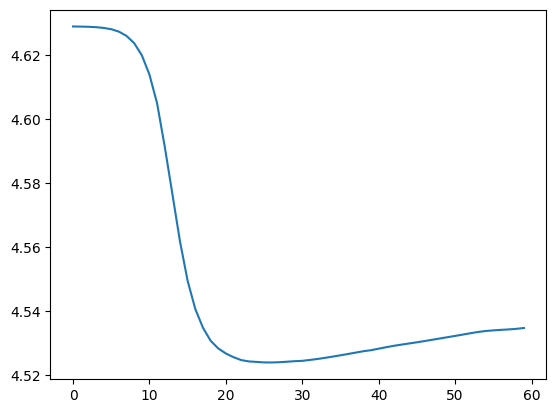

Last level, chunk-size 1250, 1 itérations.
0/1 itérations finalistes
Iteration: 0
Iteration: 25
Iteration: 50
1/1 itérations finalistes
Iteration: 0
Iteration: 25
Iteration: 50
HR-OT cost: 18.2893009185791


In [20]:
rank_schedule = rank_annealing__optimal_rank_schedule( X.shape[0] , hierarchy_depth = 6, max_Q = int(2**11), max_rank = 64 )

try:
    hrot_lr = HierarchicalRefinementOT.init_from_point_clouds(X, Y, rank_schedule, base_rank=1)
    F = hrot_lr.run(return_as_coupling=False)
    cost_hrot_lr = hrot_lr.compute_OT_cost()
    print(f'HR-OT cost: {cost_hrot_lr}')
except Exception as e:
    print(f'HROT-LR failed for sample size: {e}')
    raise e